In [167]:
import scipy.constants as SI
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [292]:
#SI.constants
Energy = 500
Ee = Energy * 1e9*SI.e
e = SI.e
me = SI.m_e
re = SI.physical_constants['classical electron radius'][0]

#Plasma parameters
n0 = 2e21 #m⁻³
L_plasma = 20 #m

wp = np.sqrt(n0*e**2/me/SI.epsilon_0)
kp = wp/SI.c
E0 = me*SI.c*wp/e
Ez = 3e9 #V/m
tau_r = 2*re/3/SI.c

K = kp/ np.sqrt(2)
A = tau_r * SI.c**2 * K**2
B = SI.c**2 * K**2
C = wp*Ez/E0
D = tau_r * SI.c**2 * K**4

#Initial gamma
gamma0 = Ee/me/(SI.c**2)
print(gamma0)

#Beam parameters
beta_matched = np.sqrt(2*gamma0)/kp
lambda_beta = 2*np.pi*beta_matched

k_beta = 2*np.pi/lambda_beta
emittance_norm = 80e-6 # m rad

sig_x = np.sqrt(beta_matched*emittance_norm/gamma0)

sig_xp = np.sqrt(1/beta_matched * emittance_norm/gamma0)
z0 = 0 # m
#For saving figures
actual = 'actual'
directory = f''
save = False

978475.5917869366


In [294]:
T = L_plasma/SI.c
n_per_beta = 250
n = round(L_plasma/lambda_beta * n_per_beta)
t, dt = np.linspace(0,T,n, retstep = True)
t_span = (0,T)

def d_gamma(x, y, gamma):
    return C - D*gamma**2*(x**2 + y**2)

def ddx(x, y, gamma):
    # x = [x,vx], same for y
    return -(C/gamma + A)*x[1] - B/gamma*x[0], -(C/gamma + A)*y[1] - B/gamma*y[0]
    

def oscillator2d(t, x):
    # x= [x,v_x, y, vy, gamma, z ,v_z]
    x_, vx_, y_, vy_, gamma_, z_, vz_ = x
    
    a_x = -(C/gamma_ + A)*vx_ - B/gamma_*x_
    a_y = -(C/gamma_ + A)*vy_ - B/gamma_*y_
    
    d_gamma = C - D*gamma_**2*(x_**2 + y_**2)
    
    v_z = np.sqrt(SI.c**2 - vx_**2 -vy_**2)
    a_z = 0

    #Set energy gain to energy loss
    #d_gamma = analytic_larmor(t, gamma_, rx, ry, phi, delta)/me/SI.c**2
    #d_gamma = 0
    return np.array([vx_, a_x, vy_, a_y, d_gamma, v_z, a_z])
    
def normal_oscillator(t, x):
    x_, vx_, y_, vy_, gamma_, z_, vz_ = x
    
    a_x = -C/gamma_*vx_ - B/gamma_*x_
    a_y = -C/gamma_*vy_ - B/gamma_*y_
    
    d_gamma = C
    v_z = np.sqrt(SI.c**2 - vx_**2 -vy_**2)
    a_z = 0
    return np.array([vx_, a_x, vy_, a_y, d_gamma, v_z, a_z])

def multistep_RK4(acc, t, y):
    solution = np.zeros((y.size, t.size))
    solution[:,0] = y
    dt = t[1] - t[0]
    for j in range(t.size-1):
        k1 = acc(dt, solution[:,j])
    
        k2 = acc(dt, solution[:,j] + k1 * dt/2)
    
        k3 = acc(dt, solution[:,j] + k2 * dt/2)
    
        k4 = acc(dt, solution[:,j] + k3 * dt)
        
        k_av = 1/6*(k1+2*k2+2*k3+k4)

        solution[:,j+1] = solution[:,j] + k_av*dt

        f_0 = k1[4]
        gamma_1 = solution[4,j] + dt*f_0
        x_1, y_1 = solution[0,j] + dt*k1[0], solution[2,j] + dt*k1[2]
            
        f_1 = d_gamma(x_1, y_1, gamma_1)
        
        g_1 = - 2*D*gamma_1*f_1*(solution[0,j+1]**2+solution[2,j+1]**2)\
        -2*D*gamma_1**2*(solution[0,j+1]*solution[1,j+1] + solution[2,j+1]*solution[3,j+1])
        
        if j>0:
            f_n = d_gamma(solution[0,j-1], solution[2,j-1], solution[4,j-1])
            solution[4,j+1] = solution[4,j] + dt*(29/48*f_1 + 5/12*f_0 - 1/48*f_n)\
            - 1/8*dt**2*g_1
        else:
            solution[4,j+1] = solution[4,j] + dt*(2/3*f_1 + 1/3*f_0) - 1/6*dt**2*g_1

    print(solution[4,0]*SI.m_e*SI.c**2/SI.e/1e9, solution[4,1]*SI.m_e*SI.c**2/SI.e/1e9)
        
    return solution

def dy_multistep(n, x):
    pass

def multistep(acc, t, y):
    solution = np.zeros((y.size, t.size))
    solution[:,0] = y
    dt = t[1] - t[0]
    for j in range(t.size-1):
        #get Acceleration for all
        a = acc(dt, solution[:,j])
        #calculate the new values due to acceleration at this location
        gamma_1 = solution[4,j] + dt*a[4]
        x_1, y_1 = solution[0,j] + dt*a[0], solution[2,j] + dt*a[2]
        vx_1, vy_1 = solution[1,j] + dt*a[1], solution[3,j] + dt*a[3]
        a_1 = acc(dt, np.array([x_1,vx_1,y_1,vy_1,gamma_1,SI.c*dt*j,SI.c]))
        
        #calculate the derivative of gamma at n+1 to be used in evolving gamma
        f_1 = a_1[4]
        
        #calculate the acceleration at point n+1
        g_x, g_y = a_1[1], a_1[3]
        
        #calculate the jerk at point n+1
        g_vx = C/gamma_1**2*f_1*vx_1 -(C/gamma_1 + A)*a[1] + B/gamma_1**2*x_1 - B/gamma_1*vx_1
        g_vy = C/gamma_1**2*f_1*vy_1 -(C/gamma_1 + A)*a[3] + B/gamma_1**2*y_1 - B/gamma_1*vy_1
        
        #calculate the acceleration of gamma at n+1
        g_gamma = - 2*D*gamma_1*f_1*(x_1**2+y_1**2) -2*D*gamma_1**2*(x_1*vx_1 + y_1*vy_1)
        
        if j>0:
            # Use the acceleration values at previous, present and future point to evolve
            
            #calculate the acceleration at point n-1
            f_n = d_gamma(solution[0,j-1], solution[2,j-1], solution[4,j-1])
            #evolve energy
            solution[4,j+1] = solution[4,j] + dt*(29/48*f_1 + 5/12*a[4] - 1/48*f_n)\
            - 1/8*dt**2*g_gamma
            
            #evolve positions
            solution[0,j+1] = solution[0,j] + dt*(29/48*vx_1 + 5/12*solution[1,j] - 1/48*solution[1,j-1])\
            - 1/8*dt**2*g_x
            solution[2,j+1] = solution[2,j] + dt*(29/48*vy_1 + 5/12*solution[3,j] - 1/48*solution[3,j-1])\
            - 1/8*dt**2*g_y
            
            #calculate the acceleration at point n-1
            a_n = acc(dt, solution[:,j-1])
            #evolve velocities
            solution[1,j+1] = solution[1,j] + dt*(29/48*a_1[1] + 5/12*a[1] - 1/48*a_n[1])\
            - 1/8*dt**2*g_vx
            solution[3,j+1] = solution[3,j] + dt*(29/48*a_1[3] + 5/12*a[3] - 1/48*a_n[3])\
            - 1/8*dt**2*g_vy
        else:
            #evolve all parameters at first position:
            solution[0,j+1] = solution[0,j] + dt*(2/3*vx_1 + 1/3*solution[1,j]) - 1/6*dt**2*g_x
            solution[2,j+1] = solution[2,j] + dt*(2/3*vy_1 + 1/3*solution[3,j]) - 1/6*dt**2*g_y 
            solution[1,j+1] = solution[1,j] + dt*(2/3*a_1[1] + 1/3*a[1]) - 1/6*dt**2*g_vx
            solution[3,j+1] = solution[3,j] + dt*(2/3*a_1[3] + 1/3*a[3]) - 1/6*dt**2*g_vy
            solution[4,j+1] = solution[4,j] + dt*(2/3*f_1 + 1/3*a[4]) - 1/6*dt**2*g_gamma

    print('done')
        
    return solution

def BDF_RK4(acc, t, y):
    solution = np.zeros((y.size, t.size))
    solution[:,0] = y
    dt = t[1] - t[0]
    for j in range(t.size-1):
        k1 = acc(dt, solution[:,j])

        k2 = acc(dt, solution[:,j] + k1 * dt/2)

        k3 = acc(dt, solution[:,j] + k2 * dt/2)

        k4 = acc(dt, solution[:,j] + k3 * dt)

        k_av = 1/6*(k1+2*k2+2*k3+k4)

        solution[:,j+1] = solution[:,j] + k_av*dt

        if j>3:
            a = acc(dt, solution[:,j])
            #solution[1,j+1] = solution[1,j] + a[1]*dt
            #solution[3,j+1] = solution[3,j] + a[3]*dt
            gamma_1 = solution[4,j] + a[4]*dt
            x_1 = solution[0,j] + a[0]*dt
            y_1 = solution[2,j] + a[2]*dt
            vx_1 = solution[1,j] + a[1]*dt
            vy_1 = solution[3,j] + a[3]*dt
            a_1 = acc(dt, np.array([x_1, vx_1, y_1, vy_1, gamma_1, 0,0]))

            """
            solution[1,j+1] = (300*solution[1,j] - 300*solution[1,j-1] + 200*solution[1,j-2]\
                              -75*solution[1,j-3] + 12*solution[1,j-4] + 60*dt*a_1[1])/137
            solution[3,j+1] = (300*solution[3,j] - 300*solution[3,j-1] + 200*solution[3,j-2]\
                              -75*solution[3,j-3] + 12*solution[3,j-4] + 60*dt*a_1[3])/137

            solution[0,j+1] = (300*solution[0,j] - 300*solution[0,j-1] + 200*solution[0,j-2]\
                              -75*solution[0,j-3] + 12*solution[0,j-4] + 60*dt*solution[1,j+1])/137
            solution[2,j+1] = (300*solution[2,j] - 300*solution[2,j-1] + 200*solution[2,j-2]\
                              -75*solution[2,j-3] + 12*solution[2,j-4] + 60*dt*solution[3,j+1])/137
            """

            f_1 = d_gamma(solution[0,j+1],solution[2,j+1],solution[4,j+1])
            solution[4,j+1] = (300*solution[4,j] - 300*solution[4,j-1] + 200*solution[4,j-2]\
                              -75*solution[4,j-3] + 12*solution[4,j-4] + 60*dt*f_1)/137
        """
        elif j==3:
            f_1 = d_gamma(solution[0,j+1],solution[2,j+1],gamma_1)
            solution[4,j+1] = 48/25*solution[4,j]-36/25*solution[4,j-1]+16/25*solution[4,j-1]\
            -3/25*solution[4,j-3]+12/25*dt*f_1
        
        elif j==2:
            f_1 = d_gamma(solution[0,j+1],solution[2,j+1],gamma_1)
            solution[4,j+1] = 18/11*solution[4,j]-9/11*solution[4,j-1]+\
            2/11*solution[4,j-2]+6/11*dt*f_1
            
        elif j==1:
            f_1 = d_gamma(solution[0,j+1],solution[2,j+1],gamma_1)
            solution[4,j+1] = 4/3*solution[4,j] -1/3*solution[4,j-1]+2/3*dt*f_1
        
        elif j==0:
            f_1 = d_gamma(solution[0,j+1],solution[2,j+1],gamma_1)
            solution[4,j+1] = solution[4,j] + f_1*dt
        """

    print(solution[4,0]*SI.m_e*SI.c**2/SI.e/1e9, solution[4,1]*SI.m_e*SI.c**2/SI.e/1e9)
        
    return solution

def BDF(acc, t, y):
    solution = np.zeros((y.size, t.size))
    solution[:,0] = y
    dt = t[1] - t[0]
    # y = x, vx, y, vy, gamma
    for j in range(t.size-1):
        a = acc(dt, solution[:,j])
        solution[1,j+1] = solution[1,j] + a[1]*dt
        solution[3,j+1] = solution[3,j] + a[3]*dt
        gamma_1 = solution[4,j] + a[4]*dt
        x_1 = solution[0,j] + a[0]*dt
        y_1 = solution[2,j] + a[2]*dt
        
        if j>3:
            solution[0,j+1] = (300*solution[0,j] - 300*solution[0,j-1] + 200*solution[0,j-2]\
                              -75*solution[0,j-3] + 12*solution[0,j-4] + 60*dt*solution[1,j+1])/137
            solution[2,j+1] = (300*solution[2,j] - 300*solution[2,j-1] + 200*solution[2,j-2]\
                              -75*solution[2,j-3] + 12*solution[2,j-4] + 60*dt*solution[3,j+1])/137
            f_1 = d_gamma(x_1,y_1,gamma_1)
            solution[4,j+1] = (300*solution[4,j] - 300*solution[4,j-1] + 200*solution[4,j-2]\
                              -75*solution[4,j-3] + 12*solution[4,j-4] + 60*dt*f_1)/137
        
        elif j==3:
            solution[0,j+1] = 48/25*solution[0,j]-36/25*solution[0,j-1]+16/25*solution[0,j-1]\
            -3/25*solution[0,j-3]+12/25*dt*solution[1,j+1]
            solution[2,j+1] = 48/25*solution[2,j]-36/25*solution[2,j-1]+16/25*solution[2,j-1]\
            -3/25*solution[2,j-3]+12/25*dt*solution[3,j+1]
            f_1 = d_gamma(x_1,y_1,gamma_1)
            solution[4,j+1] = 48/25*solution[4,j]-36/25*solution[4,j-1]+16/25*solution[4,j-1]\
            -3/25*solution[4,j-3]+12/25*dt*f_1
        
        elif j==2:
            solution[0,j+1] = 18/11*solution[0,j]-9/11*solution[0,j-1]+\
            2/11*solution[0,j-2]+6/11*dt*solution[1,j+1]
            solution[2,j+1] = 18/11*solution[2,j]-9/11*solution[2,j-1]+\
            2/11*solution[2,j-2]+6/11*dt*solution[3,j+1]
            f_1 = d_gamma(x_1,y_1,gamma_1)
            solution[4,j+1] = 18/11*solution[4,j]-9/11*solution[4,j-1]+\
            2/11*solution[4,j-2]+6/11*dt*f_1
            
        elif j==1:
            solution[0,j+1] = 4/3*solution[0,j]-1/3*solution[0,j-1]+2/3*dt*solution[1,j+1]
            solution[2,j+1] = 4/3*solution[2,j]-1/3*solution[2,j-1]+2/3*dt*solution[3,j+1]
            f_1 = d_gamma(x_1,y_1,gamma_1)
            solution[4,j+1] = 4/3*solution[4,j] -1/3*solution[4,j-1]+2/3*dt*f_1
        
        elif j==0:
            solution[0,j+1] = solution[0,j] + dt*solution[1,j+1]
            solution[2,j+1] = solution[2,j] + dt*solution[3,j+1]
            f_1 = d_gamma(x_1,y_1,gamma_1)
            solution[4,j+1] = solution[4,j] + f_1*dt
                
            
    return solution
            
def av_radiated_power(delta, gamma, k_beta, rx, ry):
    W = 1/SI.c * e**2/6/np.pi/SI.epsilon_0 * 1/SI.c**3 * ((gamma*k_beta*SI.c)**4 * \
        1/2 * (rx**2 + ry**2) + (gamma*k_beta)**6 * SI.c**4 * \
              (1/4*rx**2 * ry**2 * np.cos(2*delta) + 1/8 * (rx**4 + ry**4)))
    return W

#Calculate the analytical mean energy loss
def mean_larmor(gamma, rx, ry, z):
    k_beta = kp/np.sqrt(2*gamma)
    scale = 1#np.power(gamma/gamma0, -1/4)
    #S = np.exp(-0.5*tau_r*kp**2*SI.c*z)
    
    return e**2*z/12/np.pi/SI.epsilon_0*(gamma*k_beta)**4*\
    ((scale*rx)**2+(scale*ry)**2)

#Calculate the analytical radiated power
def analytic_larmor(t, gamma, rx, ry, phi, delta):
    k_beta = kp/np.sqrt(2*gamma)
    scale = np.power(gamma/gamma0, -1/4)
    
    return e**2*SI.c/6/np.pi/SI.epsilon_0*(gamma*k_beta)**4*\
    (np.cos(k_beta*SI.c*t + phi)**2*(scale*rx)**2\
     + np.cos(k_beta*SI.c*t + delta)**2*(scale*ry)**2)   

In [286]:
def plot_oscillations(func, normal_func, sysinit, t_span, t_eval, rx, ry, phi, delta):
    solution = solve_ivp(fun = func, y0 = sysinit, method='Radau', \
                         t_span = t_span, t_eval = t_eval)
    normal_solution = solve_ivp(fun = normal_func, y0 = sysinit, method='RK45', \
                                t_span = t_span, t_eval = t_eval)
    multi_solution = multistep(func, t_eval, sysinit)
    
    #Extract solution values
    x_ivp = solution.y[0,:]
    vx_ivp = solution.y[1,:]
    y_ivp = solution.y[2,:]
    vy_ivp = solution.y[3,:]
    
    x_multi = multi_solution[0,:]
    y_multi = multi_solution[2,:]
    
    gamma_ivp_scipy = solution.y[4,:]
    gamma_ivp_multi = multi_solution[4,:]

    t_ivp = solution.t
    z_ivp = solution.y[5,:]
    vz_ivp = solution.y[6,:]
    energy_ivp_multi = gamma_ivp_multi*me*SI.c**2 #multi
    energy_ivp_scipy = gamma_ivp_scipy*me*SI.c**2 #Radau
    
    #Extract solution values
    normal_x_ivp = normal_solution.y[0,:]
    normal_vx_ivp = normal_solution.y[1,:]
    normal_y_ivp = normal_solution.y[2,:]
    normal_vy_ivp = normal_solution.y[3,:]
    
    normal_gamma_ivp = normal_solution.y[4,:]
    normal_t_ivp = normal_solution.t
    normal_z_ivp = normal_solution.y[5,:]
    normal_vz_ivp = normal_solution.y[6,:]
    normal_energy_ivp = normal_gamma_ivp*me*SI.c**2
    
    #Vectors to store new calculated values
    Multi_loss = np.zeros(n-1)
    P = np.zeros(n-1) #Energy loss per meter
    z = np.zeros(n-1)
    energy_change = np.zeros(n-1)
    energy_gain_per_m = np.zeros(n-1)
    scipy_loss = np.empty_like(Multi_loss)
    
    for i in range(n-1):
        #Calculate the acceleration from differences in velocities
        ax = (vx_ivp[i+1] - vx_ivp[i])/dt
        ay = (vy_ivp[i+1] - vy_ivp[i])/dt
        az = (vz_ivp[i+1] - vz_ivp[i])/dt

        #Calculate a new z_array to use for plots (acceleration has n-1 points)
        z[i] = z_ivp[i]
        
        a = np.array([ax, ay])

        #Calculate gamma⁴ * (dbeta/dt)²
        A1 = gamma_ivp_multi[i]**4 * 1/SI.c**2 * np.dot(a,a)
        #Calculate energy radiated PER METER from actual larmor formula
        P[i] = 1/SI.c * e**2/6/np.pi/SI.epsilon_0 * 1/SI.c * A1 # J*m⁻¹

        #Calculate the actual energy-differences from the simulation
        energy_gain_per_m[i] = 1/SI.c * wp*Ez/E0* SI.m_e*SI.c**2
        Multi_loss[i] = Ez*SI.e - 1/SI.c * (energy_ivp_multi[i+1]-energy_ivp_multi[i])/dt# J*m⁻¹ multi
        scipy_loss[i] = Ez*SI.e - 1/SI.c * (energy_ivp_scipy[i+1]-energy_ivp_scipy[i])/dt # radau
        
    #Calculate the analytical values
    analytic_P = 1/SI.c * analytic_larmor(t_ivp, gamma_ivp_scipy, rx, ry, phi, delta)
    mean_analytic_P = mean_larmor(gamma_ivp_multi, rx, ry, z_ivp)
    
    #Plot
    fig, ax = plt.subplots(2,2, figsize=(12,10))
    fig.suptitle('Evolution of Beam Parameters')
    # Plot x and y trajectories
    ax[0,0].plot(z_ivp,x_multi*1e6, label='RR')
    ax[0,0].plot(z_ivp,normal_x_ivp*1e6, label='No RR')
    ax[0,0].grid()
    ax[0,0].set_ylabel(r'x [$\mu m$]')
    ax[0,0].set_xlabel('s (m)')
    ax[0,0].legend()
    
    ax[0, 1].plot(z_ivp,normal_y_ivp*1e6, label='No RR')
    ax[0, 1].plot(z_ivp,y_multi*1e6, label='RR')
    ax[0, 1].grid()
    ax[0, 1].set_ylabel(r'y [$\mu m$]')
    ax[0, 1].set_xlabel(r's (m)')
    ax[0, 1].legend()

    #Plot velocities
    ax[1, 0].plot(z_ivp,vx_ivp, label = r'$v_x$, RR')
    ax[1, 0].plot(z_ivp,vy_ivp, label = r'$v_y$, RR')
    ax[1, 0].plot(z_ivp,normal_vx_ivp, label = r'$v_x$, No RR')
    ax[1, 0].plot(z_ivp,normal_vy_ivp, label = r'$v_y$, No RR')
    ax[1, 0].grid()
    ax[1, 0].set_ylabel('Transverse Velocities [m/s]')
    ax[1, 0].set_xlabel('s (m)')
    ax[1, 0].legend()

    #Plot calculated energy loss from larmor formula, and the 
    #analytical mean radiated power (per meter)
    #ax[1, 1].plot(z,(energy_gain_per_m - total_energy_change)/e*1e-9, label = 'simulated')
    ax[1, 1].plot(z_ivp, energy_ivp_multi/e*1e-9, label = 'Energy')
    ax[1, 1].plot(z_ivp, normal_energy_ivp/e*1e-9, label = 'Energy w/o RR')
    ax[1, 1].grid()
    ax[1, 1].set_ylabel('Energy [GeV]')
    ax[1, 1].set_xlabel('s (m)')
    ax[1, 1].legend()

    #Plot Energy evolution
   #ax[2, 0].plot(z, total_energy_change/e*1e-9, label = 'Energy')
   ##ax[2, 0].plot(z_ivp, normal_energy_ivp/e*1e-9, label = 'normal Energy')
   ##ax[2, 0].plot(z_ivp, Brutto_energy/e*1e-9, label = 'Brutto Energy Gain')
   #ax[2, 0].grid()
   #ax[2, 0].set_ylabel('Energy (GeV)')
   #ax[2, 0].set_xlabel('s (m)')
   #ax[2, 0].legend()
#
   ##Plot analytical values for larmor formula and mean of the larmor formula
   #ax[2, 1].plot(z_ivp,analytic_P*z_ivp/e*1e-9, label = 'Simplified Larmor Formula')
   ##ax[2, 1].scatter(z_ivp, mean_analytic_P/e*1e-9, label = 'Analytical ' \
   ##+ 'Mean Radiated Power', marker = 'H', c ='tab:orange')
   #ax[2, 1].grid()
   #ax[2, 1].set_ylabel('Analytic Radiated Power (GeV/m)')
   #ax[2, 1].set_xlabel('s (m)')
   #ax[2, 1].legend()
    return x_ivp, z_ivp, energy_ivp_scipy, fig, mean_analytic_P, normal_energy_ivp-energy_ivp_scipy, z

In [5]:
x0 = 3*sig_x# m
y0 = 3*sig_x # m
x_dot0 = 0 # m/s
y_dot0 = 0 # m/s

sysinit2dx = np.array([x0, x_dot0, y0, y_dot0, gamma0, z0, SI.c])

xs, zs, Es, fig, P, total_energy_change, s = plot_oscillations(func = oscillator2d, normal_func = normal_oscillator,\
                                          sysinit = sysinit2dx, \
                                          t_span = t_span, t_eval = t,\
                                          rx = x0, ry = y0, phi = 0, delta =0)
if save:
    name = directory + f'{Energy}_GeV_single_particle_simulation_xy_in_phase.png'
    fig.savefig(name)

done


NameError: name 'total_energy_change' is not defined

In [ ]:
x0 = 0 # m
y0 = 3*sig_x  # m
x_dot0 = 0 # m/s
y_dot0 = 0 # m/s
sysinit2dy = np.array([x0, x_dot0, y0, y_dot0, gamma0, z0, SI.c])

xs, zs, Es, fig2, P, total_energy_change, s = plot_oscillations(func = oscillator2d, normal_func = normal_oscillator, sysinit = \
                                           sysinit2dy, t_span = t_span, t_eval = t,\
                                           rx = x0, ry = y0, phi = 0, delta =0)
if save:    
    name = directory + f'{Energy}_GeV_single_particle_simulation_only_y_gamma_{actual}.png'   
    fig2.savefig(name)

In [ ]:
theta = np.pi/2
x0 = 8e-6 # m
y0 = 0 # m
ry = x0
x_dot0 = 0 # m/s
y_dot0 = k_beta*x0*SI.c # m/s
sysinit2d45 = np.array([x0, x_dot0, y0, y_dot0, gamma0, z0, SI.c])


xs, zs, Es, fig3, P, total_energy_change, s = plot_oscillations(func = oscillator2d, normal_func = normal_oscillator, sysinit = sysinit2d45,\
                                           t_span = t_span, t_eval = t\
                                          , rx = x0, ry = ry, phi = 0, delta =-np.pi/2)

if save: 
    name = directory + f'{Energy}_GeV_single_particle_simulation_xy_out_of_phase_gamma_{actual}.png'
    fig3.savefig(name)

fig2 = plt.figure(figsize=(8,6))
plt.plot(z, energy_change*1e-9, label = 'analytic')
plt.plot(z,total_energy_change/e*1e-9, label = 'simulated')
plt.xlabel('z (m)')
plt.ylabel('P (GeV/m)')
plt.legend()

In [ ]:
x0 = 3*sig_x # m
y0 = 3*sig_x # m
x_dot0 = 0 # m/s
y_dot0 = 0 # m/s
sysinit2d45 = np.array([x0, x_dot0, y0, y_dot0, gamma0, z0, SI.c])

xs, zs, Es, fig4, P, total_energy_change, s = plot_oscillations(func = oscillator2d, normal_func = normal_oscillator, sysinit = sysinit2d45,\
                                           t_span = t_span, t_eval = t\
                                          , rx = x0, ry = y0, phi = 0, delta =0)
if save: 
    name = directory + f'{Energy}_GeV_single_particle_simulation_xy_in_phase_gamma_{actual}.png'
    fig4.savefig(name)

In [ ]:
print(1/SI.c*(SI.e**2/6/np.pi/SI.epsilon_0/SI.c**3 * (Ee/SI.m_e/SI.c**2)**4 * (3*sig_x*k_beta**2*SI.c**2)**2)/e*1e-9)

In [ ]:
P_av = np.mean(P)
P_int = np.trapz(P, s)/L_plasma

W = av_radiated_power(np.pi/2, Ee/SI.m_e/SI.c**2, k_beta, x0, y0)
print(Ee/SI.m_e/SI.c**2)

print(P_int/SI.e*1e-9)
print(W/SI.e*1e-9)

done


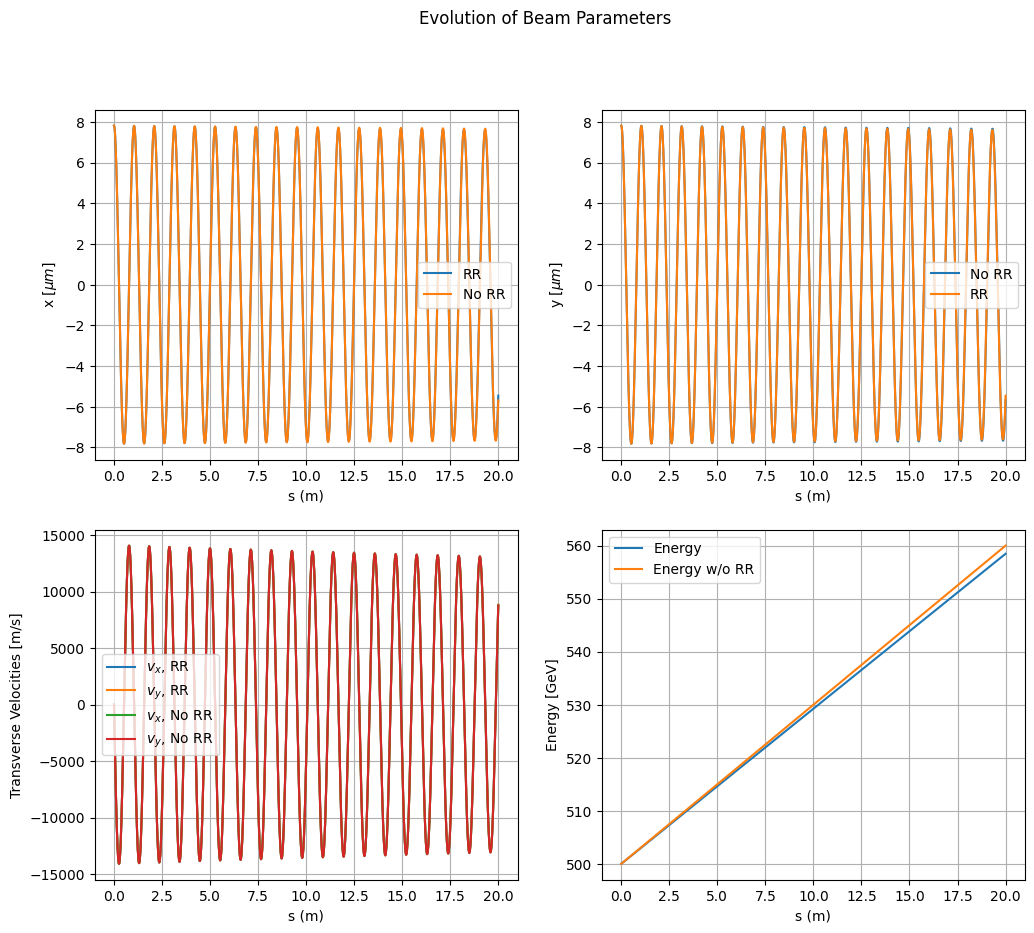

In [299]:
x0 = 3*sig_x/np.sqrt(2)# m
y0 = 3*sig_x/np.sqrt(2) # m
x_dot0 = 0 # m/s
y_dot0 = 0 # m/s

sysinit2dx = np.array([x0, x_dot0, y0, y_dot0, gamma0, z0, SI.c])

xs, zs, Es, fig, scipy, Multi, s = plot_oscillations(func = oscillator2d, normal_func = normal_oscillator,\
                                          sysinit = sysinit2dx, \
                                          t_span = t_span, t_eval = t,\
                                          rx = x0, ry = y0, phi = 0, delta =0)
if save:
    pass
name = directory + f'{Energy}_GeV_single_particle_simulation_for_comparing_2D_xy.png'
fig.savefig(name)
#print(xs[0])

In [290]:
if save:
    fig2.savefig(f'single_particle_simulation_Evolution_of_beam_parameters_{(Energy)}GeV_\
    11m_inits_z{z0*1e6}_x{x0*1e6}_y{y0*1e6}\
    _xp{x_dot0/SI.c}_yp{y_dot0/SI.c}.png')

Text(0.5, 1.0, 'Energy Loss for an Initial Energy of 1500 GeV')

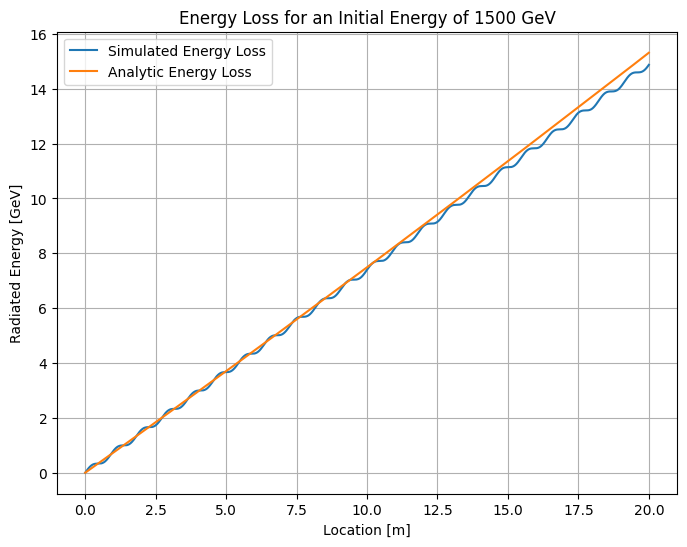

In [291]:
fig = plt.figure(figsize =(8,6))

plt.plot(zs, Multi/e*1e-9, label = 'Simulated Energy Loss')
plt.plot(zs, scipy/e*1e-9, label = 'Analytic Energy Loss')

plt.grid()
plt.legend()
plt.xlabel('Location [m]')
plt.ylabel('Radiated Energy [GeV]')
plt.title(f'Energy Loss for an Initial Energy of {Energy} GeV')
#fig.savefig(f'Energy_loss_{Energy}_GeV.png')

In [14]:
I0 = np.trapz(P/e*1e-9, s)
I1 = np.trapz(total_energy_change/e*1e-9, s)
print(I0, I1)
print((I1-I0)/I0)
#if save:
#fig.savefig(f'single_particle_simulation_Energy_loss_{(Energy)}GeV_\265
#11m_inits_z{z0*1e6}_x{x0*1e6}_y{y0*1e6}\
#_xp{x_dot0/SI.c}_yp{y_dot0/SI.c}.png')

NameError: name 'P' is not defined

In [ ]:
#plt.plot(t*SI.c, x)

In [ ]:
PS = 3.2e9 * SI.e
gamma = (7.5e12*SI.e)/SI.m_e/SI.c**2
k_beta = kp/np.sqrt(2*gamma)
Sum = PS*12*np.pi*SI.epsilon_0/SI.e**2/(gamma*k_beta)**4

In [ ]:
print(Sum)

In [ ]:
print(np.sqrt(Sum))